In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import dynetx as dn

from general_graph_utils import *

# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif")
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

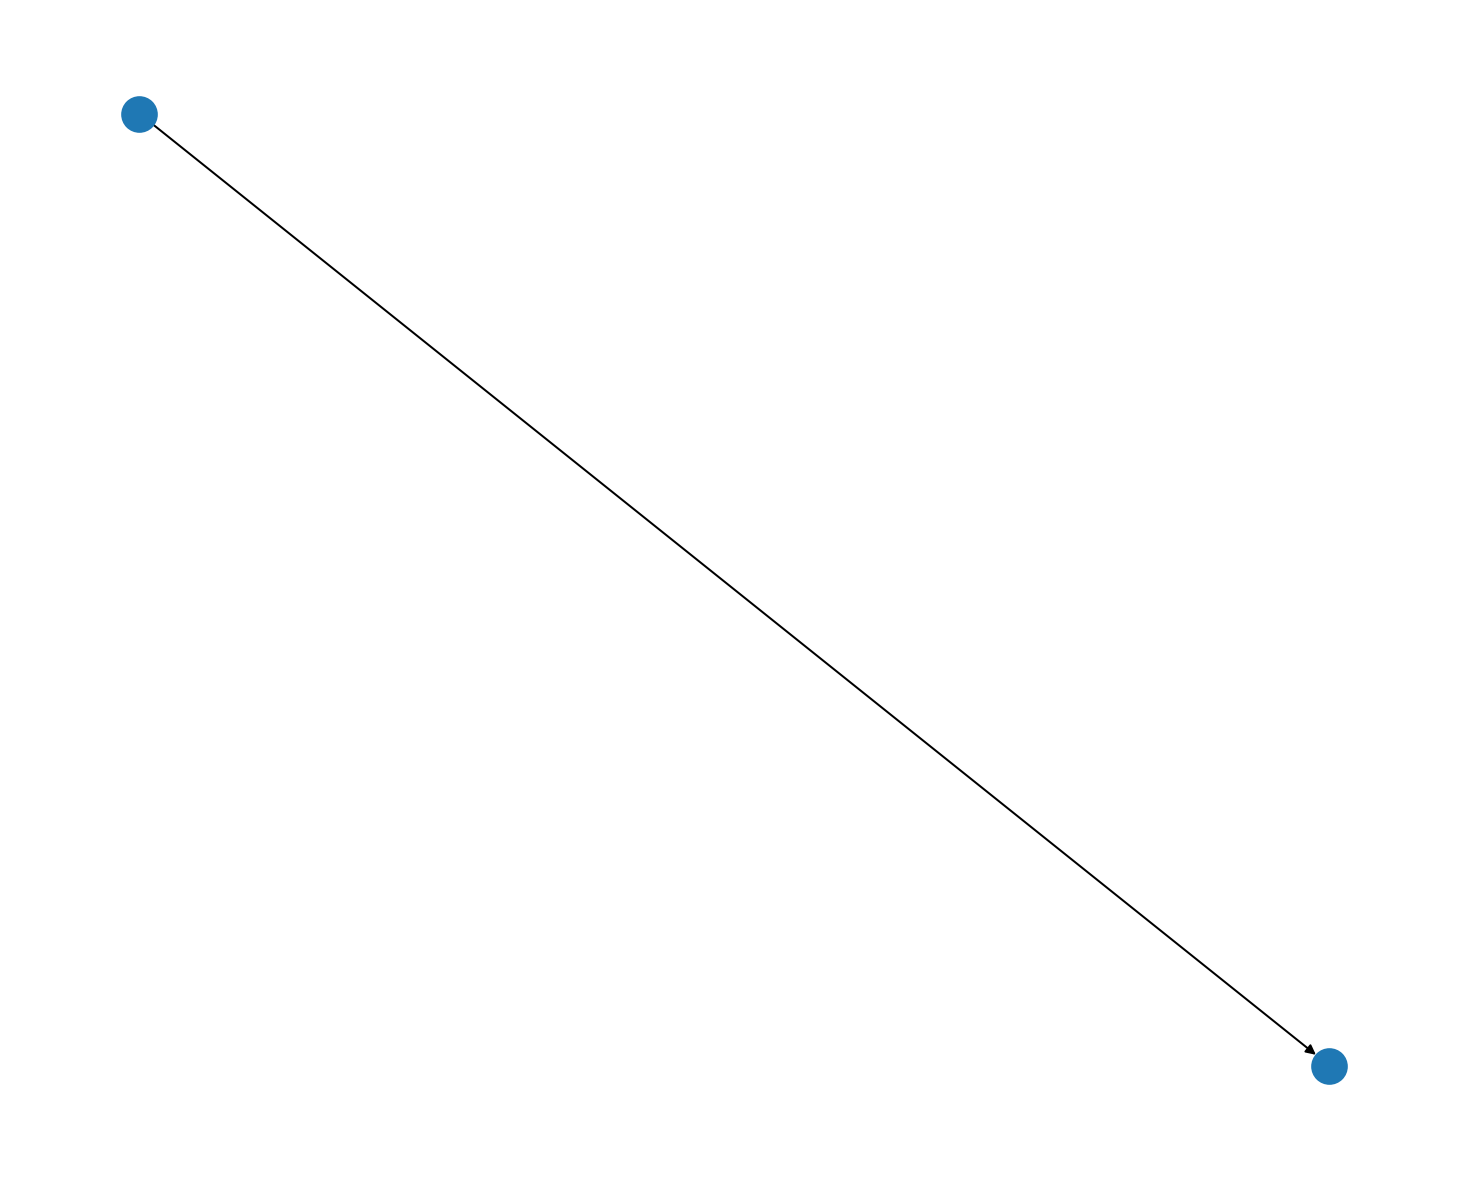

In [7]:
g = dn.DynDiGraph(edge_removal=True)
g.add_interaction(u=1, v=2, t=0)
g.add_interaction(u=1, v=2, t=0)
nx.draw(g)

In [ ]:
n = 5 # number of particles

In [3]:
n = 5 

G = nx.DiGraph()
G_ud = nx.Graph()

# determine the number of nodes in G
G_size = n

# add nodes to G and G_ud
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)
G_ud.add_nodes_from(nodes)

# add edges until the graph is strongly connected
while nx.is_strongly_connected(G) == False:
    u, v = np.random.choice(nodes, size=2,replace=False)
    G.add_edge(u,v)
    G_ud.add_edge(u,v)
    
    # add edges such that the graph is fully reversible
for edge in G.edges:
    u = edge[0]
    v = edge[1]
    if G.has_edge(v,u) == False:
        G.add_edge(v,u)
        G_ud.add_edge(v,u)

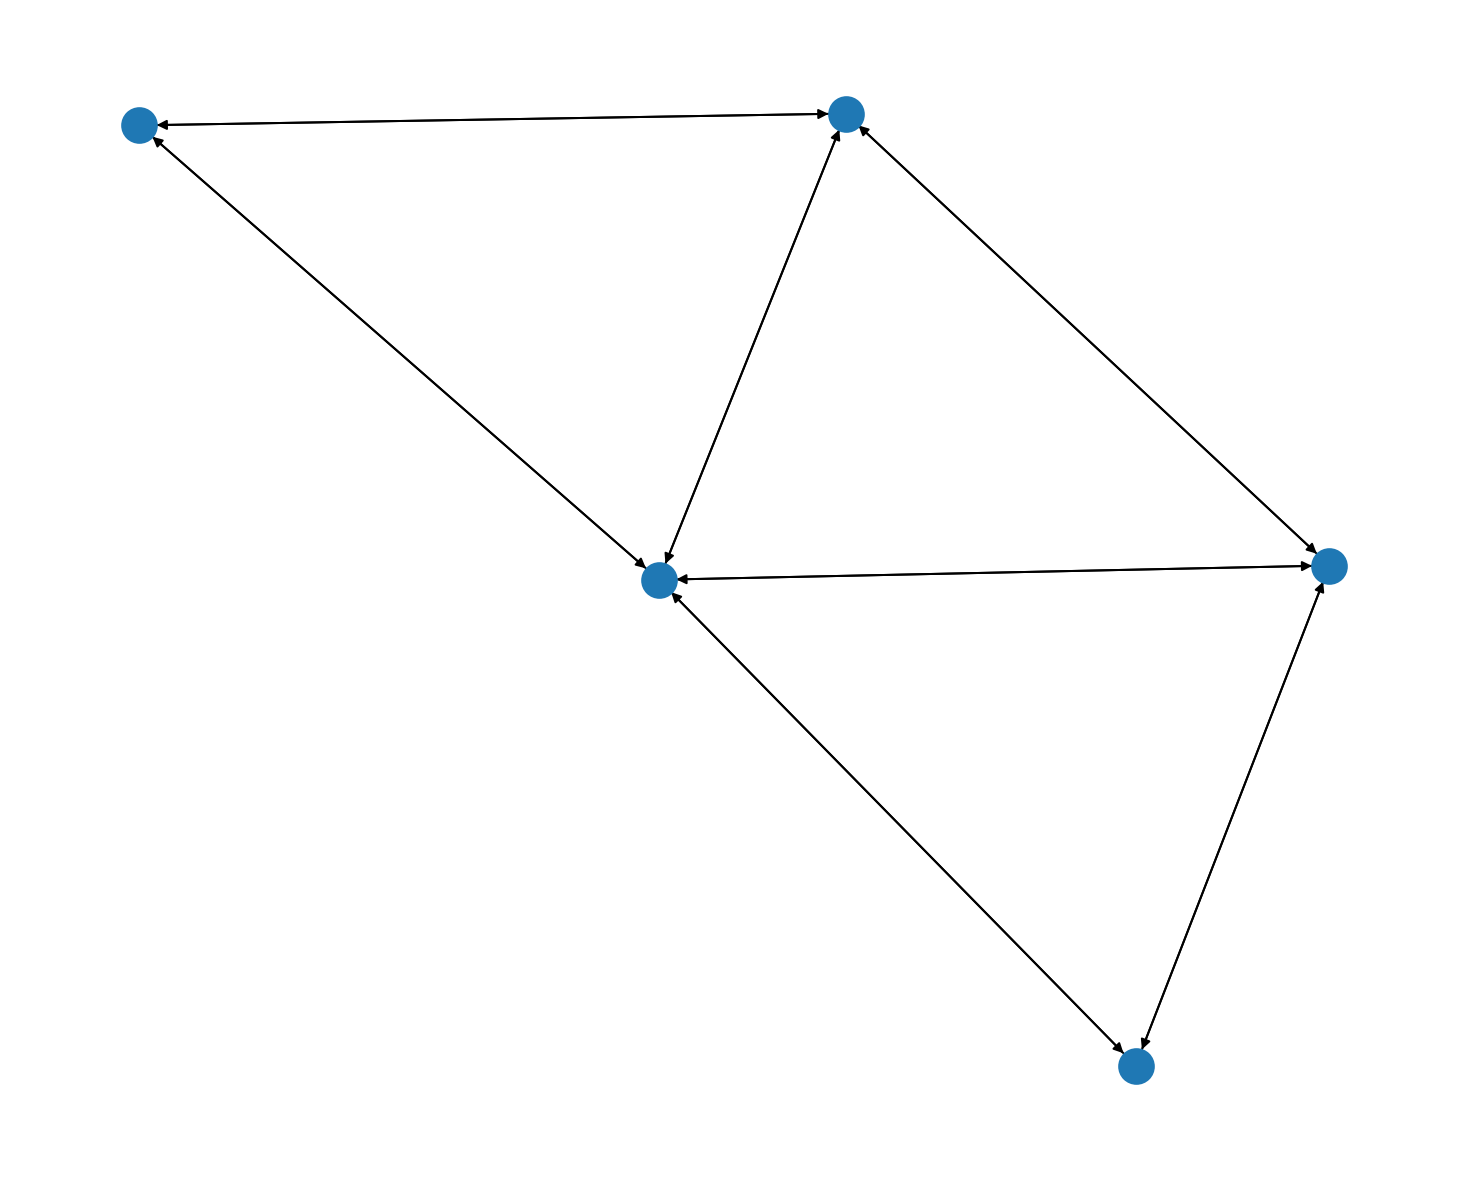

In [4]:
nx.draw(G)